In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.utils
from torchvision.utils import make_grid

import torchvision.datasets

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Introduction to Generative Adversarial Networks (GANs)

In this notebook you will build a GAN from scratch, grossly following the DCGAN architecture.

**Goals:**


1.   Build a GAN arhictecture from scratch
2.   Write the GAN loss function and train GAN from scratch
3.   Have experience with some of the instability problems inherent with training GANs.
4.   [Bonus] Extend the unconditional GAN into a conditional GAN.



## 1. Getting Started

We will work with the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. It contains 60,000 images size 28x28 of handwritten digits, from 0 to 9.

## 1. Dataloading

### 1.1 Define some hyperparameters and transforms


In [113]:
batch_size = 128 # Images per batch

# Resize to 32x32 for easier upsampling/downsampling
mytransform = transforms.Compose([transforms.Resize(32),
                                  transforms.ToTensor(),
                                 transforms.Normalize((.5), (.5))]) # normalize between [-1, 1] with tanh activation

mnist_train = torchvision.datasets.MNIST(root='.', download=True, transform=mytransform)

In [114]:
dataloader = DataLoader(dataset=mnist_train,
                         batch_size=batch_size,
                         shuffle=True)

In [115]:
# plot some images
real_batch, real_labels = next(iter(dataloader))

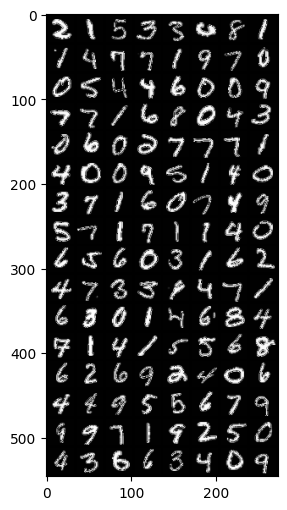

In [116]:
plt.imshow(transforms.ToPILImage()(make_grid(real_batch)))

## 2. Model Architecture

We will follow the general architecture of a DCGAN - or deep convolutional GAN. This [influential paper](https://arxiv.org/pdf/1511.06434v2.pdf) produced much of the foundation for modern GANs and how to train them.

(GANs are notoriously **hard** to train, we will try to get a feeling why in this notebook.)


Complete the function `get_upscaling_block`. Then, use the function to define our model defined as follows:

Input: Random "noise" $z$ shaped `[n_batch, n_z]`

Output: Generated image size `[n_batch, 1, 32, 32]` in range [-1, 1]

1. Reshape z into `[n_batch, n_z, 1, 1]` to make it into an "image"
2. First upscaling block $\rightarrow$ `[n_batch, ngf*4, 4, 4]`
3. Second upscaling block $\rightarrow$ `[n_batch, ngf*2, 8, 8]`
4. Third upscaling block $\rightarrow$ `[n_batch, ngf, 16, 16]`
5. Fourth (and last) upscaling block $\rightarrow$ `[n_batch, 1, 32, 32]`

## 2.1. The Generator



The generator performs subsequent upsampling blocks, transforming a latent vector shaped [batch_size, latent_size] into an image (values in [-1, 1]).

The generator block will consists of:
- Transpose Convolution
- Batch Norm
- ReLU

In [122]:
def get_upscaling_block(channels_in, channels_out, kernel, stride, padding, last_layer=False):
    '''
    Each transpose conv will be followed by BatchNorm and ReLU,
    except the last block (which is only followed by tanh)
    '''
    if last_layer:
      return torch.nn.Sequential(torch.nn.ConvTranspose2d(channels_in,channels_out,kernel,stride,padding),
                                  torch.nn.Tanh())
    else:
      return torch.nn.Sequential(torch.nn.ConvTranspose2d(channels_in,channels_out,kernel,stride,padding),
                                 torch.nn.BatchNorm2d(channels_out),
                                 torch.nn.ReLU()
                                 )

class Generator(nn.Module):
    def __init__(self, nz, ngf, nchannels=1):
        '''
        nz: The latent size (100 in our case)
        ngf: The channel-size before the last layer (32 our case)
        '''
        super().__init__()

        self.model = torch.nn.Sequential(get_upscaling_block(nz, ngf*4, (4,4), 1, 0, last_layer=False),
                                         get_upscaling_block(ngf*4, ngf*2, (4,4), 2, 1, last_layer=False),
                                         get_upscaling_block(ngf*2, ngf, (4,4), 2, 1, last_layer=False),
                                         get_upscaling_block(ngf, 1, (4,4), 2, 1, last_layer=True))


    def forward(self, z):
        x = z.unsqueeze(2).unsqueeze(2)
        return self.model(x)


### 2.1.3. Sanity Tests

In [123]:
nz = 1000
z = torch.randn(batch_size, nz)

In [124]:
G = Generator(nz=nz, ngf=16)
assert G(z).shape == (batch_size, 1, 32, 32)

G = Generator(nz=nz, ngf=16)
assert G(z).shape == (batch_size, 1, 32, 32)

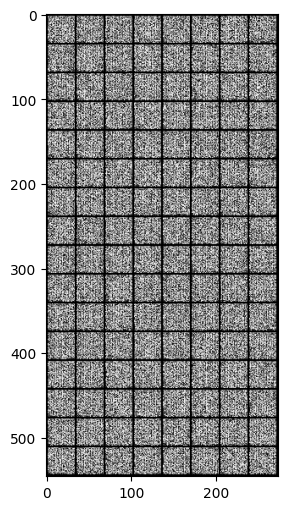

In [125]:
# visualize the output - at first it should just look like random noise!!
x_fake = G(z)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)))

## 2.2. The discriminator

The discriminator will be a mirror image of the generator.

The discriminator will also use a fully convolutional architecutre, with each block consisting of:
- Conv layer
- BatchNorm
- ReLU

Complete the function `get_downscaling_block` and then use it to define the following architecture for the discriminator:

Input: Image shaped `[n_batch, 1, 32, 32]` (in [-1, 1])
Output: Discriminator scores `[n_batch, 1]` in range [0, 1]

1. First downscaling block $\rightarrow$ `[n_batch, ndf, 16, 16]`
2. Second downscaling block $\rightarrow$ `[n_batch, ndf*2, 8, 8]`
3. Third downscaling block $\rightarrow$ `[n_batch, ndf*4, 4, 4]`
4. Last downscaling block $\rightarrow$ `[n_batch, 1]`

In [126]:
def get_downscaling_block(channels_in, channels_out, kernel, stride, padding, use_batch_norm=True, is_last=False):

    if is_last:
        return nn.Sequential(
            nn.Conv2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding, bias=False),
            nn.Sigmoid()
        )

    elif not use_batch_norm:
        return nn.Sequential(
            nn.Conv2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding, bias=False),
            nn.LeakyReLU(negative_slope=0.2)
        )

    else:
        return nn.Sequential(
            nn.Conv2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(channels_out),
            nn.LeakyReLU(negative_slope=0.2)
        )
class Discriminator(nn.Module):
    def __init__(self, ndf, nchannels=1):
        super().__init__()


        self.model = torch.nn.Sequential(get_downscaling_block(nchannels, ndf, (4,4), 2, 1, is_last=False),
                                         get_downscaling_block(ndf, ndf*2, (4,4), 2, 1, is_last=False),
                                         get_downscaling_block(ndf*2, ndf*4, (4,4), 2, 1, is_last=False),
                                         get_downscaling_block(ndf*4, 1, (4,4), 1, 0, is_last=True))


    def forward(self, x):
        return self.model(x).squeeze(1).squeeze(1)

### 2.2.3 Sanity Checking

In [127]:
print(real_batch.shape)
print(real_labels.shape)

torch.Size([128, 1, 32, 32])
torch.Size([128])


In [128]:
real_batch, real_labels = next(iter(dataloader))

In [129]:
D = Discriminator(ndf=32, nchannels=1)
assert D(real_batch).shape == (real_batch.shape[0], 1)

# 3. Training

## 3.1 Loss
The essential thing to remember is that the logistic and the non-saturating logistic GAN losses can be written exclusively using the [binary cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html). Our GAN loss will be defined ONLY using the following criterion:



In [130]:
criterion = nn.BCELoss() # we will build off of this to make our final GAN loss!

## 3.2 Helper functions

We will need a few helper functions.
1. First, we need to continuously sample z from a Gaussian distribution.
2. Secondly, we need to make our "ground-truth" labels when using the BCE loss. This should output vectors of either 0s or 1s.

In [131]:
def sample_z(batch_size, nz):
    return torch.randn(batch_size, nz, device=device)

# this is for the real ground-truth label
def get_labels_one(batch_size):
    r = torch.ones(batch_size, 1)
    return r.to(device)

# this is for the generated ground-truth label
def get_labels_zero(batch_size):
    r = torch.zeros(batch_size, 1)
    return r.to(device)


# To initialize the weights of a GAN, the DCGAN paper found that best results are obtained
# with Gaussian initialization with mean=0; std=0.02
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# for visualization
to_pil = transforms.ToPILImage()
renorm = transforms.Normalize((-1.), (2.))

## 3.3 Creating the optimizers and hyperparameters

The original DCGAN paper shows that Adam works well in the generator and the discriminator with a learning rate of 0.0002 and Beta1 = 0.5.

Define your optimizers

In [132]:
nz = 100
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))


## 3.3 Training!

Now for the fun part, training!
Training a GAN consists in making an update to the discriminator, then the generator.
Training a GAN requires BABYSITTING!! Remember that many things can go wrong when training a GAN:
- The discriminator is too strong for the generator - the generator cannot improve.
- The generator easily fools the discriminator - cannot learn.
- Mode collapse - generator is not capable of generating diverse images.

In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        batch_size = im.shape[0]


        # 1. sample a z vector
        z = sample_z(batch_size, nz)

        # 2. Generate a fake image
        fake_image = netG(z)

        # 3. Classify real image with D
        y = netD(im)

        # 4. Classify fake image with D
        y_hat = netD(fake_image)

        ###
        ### Discriminator
        ###

        d_loss = criterion(y_hat,get_labels_zero(batch_size)) +  criterion(y,get_labels_one(batch_size))#     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###

        fake_image = netG(z)
        y_hat = netD(fake_image)

        g_loss = criterion(y_hat,get_labels_one(batch_size))#      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = y.mean().item()
        avg_fake_score = y_hat.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

Output hidden; open in https://colab.research.google.com to view.

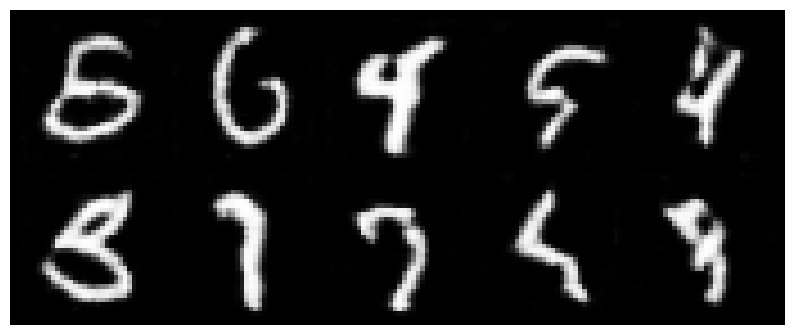

In [ ]:
import torchvision
import matplotlib.pyplot as plt

# Génération du batch de 10 images
z = sample_z(10, 100)
generated_images = netG(z).detach().cpu()  # Déplacer sur le CPU et détacher du graphe

# Si les images sont normalisées dans [-1, 1], renormaliser vers [0, 1]
generated_images = (generated_images + 1) / 2  # Renormaliser

# Créer une grille de toutes les images dans le batch
grid = torchvision.utils.make_grid(generated_images, nrow=5)  # Affiche 5 images par ligne
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))  # Permuter [C, H, W] en [H, W, C] pour plt.imshow
plt.axis("off")
plt.show()


## Reduce ngf

In [ ]:
nz = 100
ngf = 8
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

nb_epochs = 5

g_losses = []
d_losses = []

j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        batch_size = im.shape[0]


        # 1. sample a z vector
        z = sample_z(batch_size, nz)

        # 2. Generate a fake image
        fake_image = netG(z)

        # 3. Classify real image with D
        y = netD(im)

        # 4. Classify fake image with D
        y_hat = netD(fake_image)

        ###
        ### Discriminator
        ###

        d_loss = criterion(y_hat,get_labels_zero(batch_size)) +  criterion(y,get_labels_one(batch_size))#     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###

        fake_image = netG(z)
        y_hat = netD(fake_image)
        g_loss = criterion(y_hat,get_labels_one(batch_size))#      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = y.mean().item()
        avg_fake_score = y_hat.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

Output hidden; open in https://colab.research.google.com to view.

## change weight initialization

In [ ]:
nz = 100
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

nb_epochs = 5

g_losses = []
d_losses = []

j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        batch_size = im.shape[0]


        # 1. sample a z vector
        z = sample_z(batch_size, nz)

        # 2. Generate a fake image
        fake_image = netG(z)

        # 3. Classify real image with D
        y = netD(im)

        # 4. Classify fake image with D
        y_hat = netD(fake_image)

        ###
        ### Discriminator
        ###

        d_loss = criterion(y_hat,get_labels_zero(batch_size)) +  criterion(y,get_labels_one(batch_size))#     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###

        fake_image = netG(z)
        y_hat = netD(fake_image)
        g_loss = criterion(y_hat,get_labels_one(batch_size))#      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = y.mean().item()
        avg_fake_score = y_hat.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

Output hidden; open in https://colab.research.google.com to view.

## Change the loss of the generator for the "true" equation

In [ ]:
nz = 100
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

nb_epochs = 5

g_losses = []
d_losses = []

j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        batch_size = im.shape[0]


        # 1. sample a z vector
        z = sample_z(batch_size, nz)

        # 2. Generate a fake image
        fake_image = netG(z)

        # 3. Classify real image with D
        y = netD(im)

        # 4. Classify fake image with D
        y_hat = netD(fake_image)

        ###
        ### Discriminator
        ###

        d_loss = criterion(y_hat,get_labels_zero(batch_size)) +  criterion(y,get_labels_one(batch_size))#     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###

        fake_image = netG(z)
        y_hat = netD(fake_image)
        g_loss = -criterion(y_hat,get_labels_zero(batch_size))#      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = y.mean().item()
        avg_fake_score = y_hat.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

Output hidden; open in https://colab.research.google.com to view.

## Change the learning rates

### Reducing the learning rate of the generator

In [ ]:
nz = 100
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0002
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

nb_epochs = 5

g_losses = []
d_losses = []

j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        batch_size = im.shape[0]


        # 1. sample a z vector
        z = sample_z(batch_size, nz)

        # 2. Generate a fake image
        fake_image = netG(z)

        # 3. Classify real image with D
        y = netD(im)

        # 4. Classify fake image with D
        y_hat = netD(fake_image)

        ###
        ### Discriminator
        ###

        d_loss = criterion(y_hat,get_labels_zero(batch_size)) +  criterion(y,get_labels_one(batch_size))#     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###

        fake_image = netG(z)
        y_hat = netD(fake_image)
        g_loss = criterion(y_hat,get_labels_one(batch_size))#      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = y.mean().item()
        avg_fake_score = y_hat.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

Output hidden; open in https://colab.research.google.com to view.

### Reducing the learning rate of the discriminator

In [ ]:
nz = 100
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.00009
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

nb_epochs = 5

g_losses = []
d_losses = []

j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        batch_size = im.shape[0]


        # 1. sample a z vector
        z = sample_z(batch_size, nz)

        # 2. Generate a fake image
        fake_image = netG(z)

        # 3. Classify real image with D
        y = netD(im)

        # 4. Classify fake image with D
        y_hat = netD(fake_image)

        ###
        ### Discriminator
        ###

        d_loss = criterion(y_hat,get_labels_zero(batch_size)) +  criterion(y,get_labels_one(batch_size))#     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###

        fake_image = netG(z)
        y_hat = netD(fake_image)
        g_loss = criterion(y_hat,get_labels_one(batch_size))#      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = y.mean().item()
        avg_fake_score = y_hat.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

Output hidden; open in https://colab.research.google.com to view.

## 30 epochs

In [ ]:
nz = 100
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

nb_epochs = 30

g_losses = []
d_losses = []

j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        batch_size = im.shape[0]


        # 1. sample a z vector
        z = sample_z(batch_size, nz)

        # 2. Generate a fake image
        fake_image = netG(z)

        # 3. Classify real image with D
        y = netD(im)

        # 4. Classify fake image with D
        y_hat = netD(fake_image)

        ###
        ### Discriminator
        ###

        d_loss = criterion(y_hat,get_labels_zero(batch_size)) +  criterion(y,get_labels_one(batch_size))#     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###

        fake_image = netG(z)
        y_hat = netD(fake_image)
        g_loss = criterion(y_hat,get_labels_one(batch_size))#      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = y.mean().item()
        avg_fake_score = y_hat.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

Output hidden; open in https://colab.research.google.com to view.

##  Reduce $n_z$

In [ ]:
nz = 10
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

nb_epochs = 5

g_losses = []
d_losses = []

j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        batch_size = im.shape[0]


        # 1. sample a z vector
        z = sample_z(batch_size, nz)

        # 2. Generate a fake image
        fake_image = netG(z)

        # 3. Classify real image with D
        y = netD(im)

        # 4. Classify fake image with D
        y_hat = netD(fake_image)

        ###
        ### Discriminator
        ###

        d_loss = criterion(y_hat,get_labels_zero(batch_size)) +  criterion(y,get_labels_one(batch_size))#     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###

        fake_image = netG(z)
        y_hat = netD(fake_image)
        g_loss = criterion(y_hat,get_labels_one(batch_size))#      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = y.mean().item()
        avg_fake_score = y_hat.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

Output hidden; open in https://colab.research.google.com to view.

## Using a learned GAN, take 2 noise vectors $z_1$ and $z_2$ and generate the images corresponding to several linear interpolations

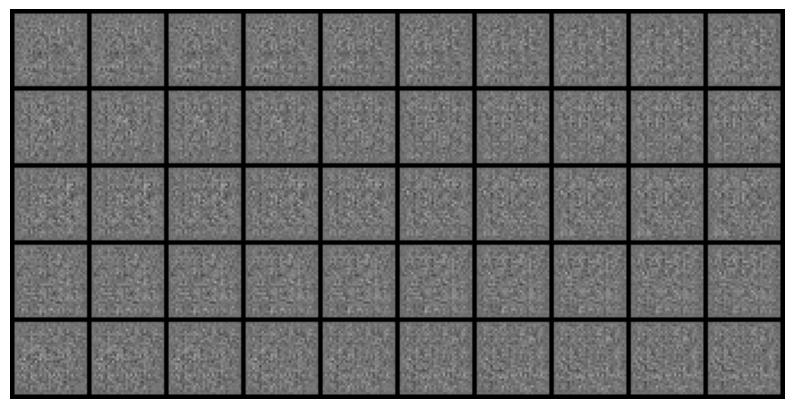

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

z1 = sample_z(5, nz)
z2 = sample_z(5, nz)
alphas = np.linspace(0, 1, 10)

# Initialize a list to store all generated images
all_images = []

for i in range(z1.size(0)):
    for alpha in alphas:
        z = alpha * z1[i] + (1 - alpha) * z2[i]
        z = z.unsqueeze(0)  # Add batch dimension
        fake_im = netG(z)
        un_norm = renorm(fake_im)  # for visualization
        all_images.append(un_norm[0])  # Append single image

# Concatenate all images into a single tensor
all_images = torch.stack(all_images, dim=0)

# Create a grid with nrow equal to the number of alphas to organize the display
grid = torchvision.utils.make_grid(all_images, nrow=len(alphas))

# Convert the grid to PIL and display
pil_grid = to_pil(grid)
plt.imshow(pil_grid)
plt.axis('off')
plt.show()


## Generate 64x64 images

In [ ]:
batch_size = 128 # Images per batch

# Resize to 32x32 for easier upsampling/downsampling
mytransform = transforms.Compose([transforms.Resize(64),
                                  transforms.ToTensor(),
                                 transforms.Normalize((.5), (.5))]) # normalize between [-1, 1] with tanh activation

mnist_train = torchvision.datasets.MNIST(root='.', download=True, transform=mytransform)

In [ ]:
dataloader = DataLoader(dataset=mnist_train,
                         batch_size=batch_size,
                         shuffle=True)

In [ ]:
batch_size = 128 # Images per batch

# Resize to 32x32 for easier upsampling/downsampling
mytransform = transforms.Compose([transforms.Resize(64),
                                  transforms.ToTensor(),
                                 transforms.Normalize((.5), (.5))]) # normalize between [-1, 1] with tanh activation

mnist_train = torchvision.datasets.MNIST(root='.', download=True, transform=mytransform)

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nchannels=1):
        '''
        nz: The latent size (100 in our case)
        ngf: The channel-size before the last layer (32 our case)
        '''
        super().__init__()

        self.model = torch.nn.Sequential(get_upscaling_block(nz, ngf*8, (4,4), 1, 0, last_layer=False),
                                         get_upscaling_block(ngf*8, ngf*4, (4,4), 2, 1, last_layer=False),
                                         get_upscaling_block(ngf*4, ngf*2, (4,4), 2, 1, last_layer=False),
                                         get_upscaling_block(ngf*2, ngf, (4,4), 2, 1, last_layer=False),
                                         get_upscaling_block(ngf, 1, (4,4), 2, 1, last_layer=True))


    def forward(self, z):
        x = z.unsqueeze(2).unsqueeze(2)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, ndf, nchannels=1):
        super().__init__()

        self.model = torch.nn.Sequential(
            get_downscaling_block(nchannels, ndf, (3,3), 2, 1, is_last=False),
            get_downscaling_block(ndf, ndf*2, (3,3), 2, 1, is_last=False),
            get_downscaling_block(ndf*2, ndf*4, (3,3), 2, 1, is_last=False),
            get_downscaling_block(ndf*4, ndf*8, (3,3), 2, 1, is_last=False),
            get_downscaling_block(ndf*8, 1, (4,4), 1, 0, is_last=True)
        )

    def forward(self, x):
        return self.model(x).squeeze(1).squeeze(1)

In [ ]:
nz = 1000
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

nb_epochs = 5

g_losses = []
d_losses = []

j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        batch_size = im.shape[0]


        # 1. sample a z vector
        z = sample_z(batch_size, nz)

        # 2. Generate a fake image
        fake_image = netG(z)

        # 3. Classify real image with D
        y = netD(im)

        # 4. Classify fake image with D
        y_hat = netD(fake_image)

        ###
        ### Discriminator
        ###

        d_loss = criterion(y_hat,get_labels_zero(batch_size)) +  criterion(y,get_labels_one(batch_size))#     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###

        fake_image = netG(z)
        y_hat = netD(fake_image)
        g_loss = criterion(y_hat,get_labels_one(batch_size))#      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = y.mean().item()
        avg_fake_score = y_hat.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

Output hidden; open in https://colab.research.google.com to view.

# 4. Conditional GANs

A simple way to improve training performance and obtain control of the generation is to provide extra information into the Generator and the Discriminator, known as **Conditional GANs**. In this case, we will provide the class label (digit number of MNIST) into both the generator and the discriminator. This will help both of the networks.

## 4.1 Conditional Generator and Discriminator

Complete the ConditionalDiscriminator and ConditionalGenerator classes using your GAN building blocks (`get_upsampling_block` and `get_downsampling_block` functions).


### 4.1.1 Generator

In [88]:
# GENERATOR

'''
The conditional generator needs the label information as well as the latent vector.
We will combine the latent vector and the class information in the following way:

- The class information for the generator will be represented as a one-hot
vector sized `[batch_size, 10]` (since there are 10 classes in MNIST)
- The latent vector for the generator will still be sized `[batch_size, nz]`

1. Transform both of these modalities into 'images' (by adding dimensions)
2. Like before, apply the first upscaling block to both of these 'images'. We will now have 2 separate blocks sized

'''

class ConditionalGenerator(nn.Module):
    def __init__(self, nz, nc, ngf, nchannels=1):
        super().__init__()

        self.upscaling_z = get_upscaling_block(nz, ngf*8, (4,4), 1, 0)
        self.upscaling_c = get_upscaling_block(nc, ngf*8, (4,4), 1, 0)

        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #


        self.rest_model = torch.nn.Sequential(get_upscaling_block(ngf*16, ngf*8, (4,4), 2, 1, last_layer=False),
                                         get_upscaling_block(ngf*8, ngf*4, (4,4), 2, 1, last_layer=False),
                                         get_upscaling_block(ngf*4, nchannels, (4,4), 2, 1, last_layer=True))


        ###################

    def forward(self, x, y):
        x = x.unsqueeze(2).unsqueeze(2)
        y = y.unsqueeze(2).unsqueeze(2)

        z_features = self.upscaling_z(x)
        c_features = self.upscaling_c(y)
        input = torch.concat((z_features,c_features),dim=1)

        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        return self.rest_model(input)

### 4.1.2 Discriminator

In [89]:
# Discriminator

'''
The conditional discriminator needs the label information as well as the latent vector. We will combine the latent vector and the class information in the following way:

- The class information for the discriminator will be represented as a one-hot vector sized `[batch_size, 10]` (since there are 10 classes in MNIST)
- The latent vector for the generator will still be sized `[batch_size, nz]`

1. Transform both of these modalities into 'images' (by adding dimensions)
2. Like before, apply the first upscaling block to both of these 'images'. We will now have 2 separate blocks sized

'''

class ConditionalDiscriminator(nn.Module):
    def __init__(self, ndf, nc, nchannels=1):
        super().__init__()
        self.downscale_x = get_downscaling_block(nchannels, ndf*2, (4,4), 2, 1, use_batch_norm=False)
        self.downscale_y = get_downscaling_block(nc, ndf*2, (4,4), 2, 1, use_batch_norm=False)

        ###################
        #                 #
        # YOUR CODE HERE  #

        self.rest = torch.nn.Sequential(get_downscaling_block(ndf*4, ndf*8, (4,4), 2, 1, is_last=False),
                                         get_downscaling_block(ndf*8, ndf*16, (4,4), 2, 1, is_last=False),
                                         get_downscaling_block(ndf*16, 1, (4,4), 1, 0, is_last=True)
                                         )
        #                 #
        ###################

    def forward(self, x, y):

        y = y.unsqueeze(2).unsqueeze(2)
        y = y.expand(-1, -1, 32, 32)
        x_features = self.downscale_x(x)
        c_features = self.downscale_y(y)
        input = torch.concat((x_features,c_features),dim=1)
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        res = self.rest(input).squeeze(1).squeeze(1)
        return res # remove spatial dimensions

### 4.1.3 Sanity Checks

In [90]:
# Conditional Discriminator Sanity Checking

cD = ConditionalDiscriminator(ndf=32, nc=10, nchannels=1)
assert cD(real_batch, F.one_hot(real_labels).float()).shape == (real_batch.shape[0], 1)

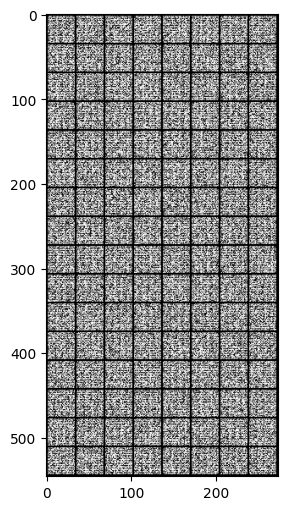

In [91]:
# CONDITIONAL GENERATOR SANITY CHECKING

z = torch.randn(batch_size, nz)
y = F.one_hot(real_labels).float()

cG = ConditionalGenerator(nz=nz, ngf=16, nc=10)
x_fake = cG(z, y)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)))

## 4.2 Training

In [92]:
nz = 100
ndf = 32
ngf = 32
nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

nc= 10

netD = ConditionalDiscriminator(ndf, nc, nchannels=1).to(device)
netG = ConditionalGenerator(nz, nc, ngf).to(device)

netG.apply(weights_init)
netD.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))



In [93]:
nb_epochs = 5

g_losses = []
d_losses = []

j = 0

z_test = sample_z(100, nz)  # we generate the noise only once for testing


for epoch in range(nb_epochs):

    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, labels = batch
        im = im.to(device)


        y = F.one_hot(labels).float().to(device)

        cur_batch_size = im.shape[0]


        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        # 1. sample a z vector
        z = sample_z(cur_batch_size,nz).to(device)

        # 2. Generate a fake image
        fake_image = netG(z,y)

        # 3. Classify real image with D
        real_score = netD(im,y)
        # 4. Classify fake image with D
        fake_score = netD(fake_image,y)

        ###
        ### Discriminator
        ###

        d_loss = criterion(real_score,get_labels_one(cur_batch_size)) + criterion(fake_score ,get_labels_zero(cur_batch_size))
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###
        fake_score = netD(fake_image,y)

        g_loss = criterion(fake_score,get_labels_one(cur_batch_size))
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = real_score.mean().item()
        avg_fake_score = fake_score.mean().item()

        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")

        if i % display_freq == 0:
            labels = torch.arange(0, 10).expand(size=(10, 10)).flatten().to(device)
            y = F.one_hot(labels).float().to(device)
            fake_im = netG(z_test, y)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=10)
            pil_grid = to_pil(grid)

            plt.imshow(pil_grid)
            plt.show()


            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1


Output hidden; open in https://colab.research.google.com to view.

## 4.2 Testing
Visualization of the impact of z on generation. All digits in the same column have the same noise vector z.

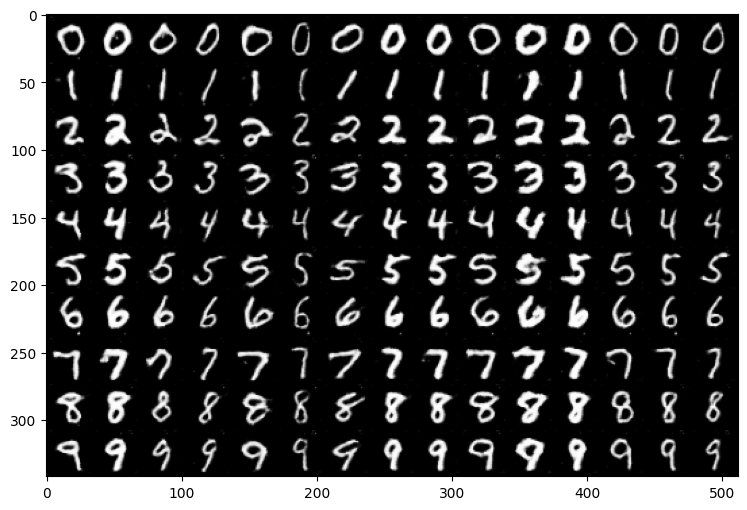

In [94]:
n_ex = 15
n_classes = 10

z = sample_z(n_ex, nz).repeat(n_classes, 1) #.expand(10, nz)

netG.eval()

labels = torch.arange(n_classes).unsqueeze(0).reshape(-1, 1).repeat(1, n_ex).flatten().to(device)

ys = F.one_hot(labels).float()
fake_ims = netG(z, ys)

un_norm= renorm(fake_ims) # for visualization
grid = torchvision.utils.make_grid(un_norm, nrow=n_ex)
pil_grid = to_pil(grid)

plt.imshow(pil_grid)
plt.show()
